# Data

In [1]:
random_state=190624

### Raw

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import joblib
import itertools
%matplotlib inline


import sys
import os
sys.path.append(os.path.join(
    os.path.abspath(os.path.pardir), 'src'
))

import nzcompetition
from nzcompetition.preparation import make_prep_pipeline

In [1]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import (
    Ridge, 
    Lasso, 
    ElasticNet, 
    ElasticNetCV, 
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, 
    AdaBoostRegressor
)
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV
)
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [4]:
y_col = 'performance'
# for plotting
lim=[0, 1.5]

In [5]:
X_train, y, X_test = nzcompetition.get_raw_data(target=y_col)
X_train, y = nzcompetition.drop_dup(X_train, y)

In [6]:
print(X_train.shape, y.shape, X_test.shape)

(122, 114) (122,) (61, 114)


### Full features

In [7]:
prep_pipe = make_prep_pipeline()

In [8]:
X_train_prep = prep_pipe.fit_transform(X_train)

/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/seqtransform.py:242: RuntimeWarning: Mean of empty slice
  protdf['pI'] = np.nanmean(protdf[['pI_u', 'pI_p', 'pI_green']], axis=1)
/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/seqtransform.py:246: RuntimeWarning: Mean of empty slice
  protdf['molweight'] = np.nanmean(protdf[['molweight_u', 'molweight_p']], axis=1)
/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/numtransform.py:221: RuntimeWarning: Mean of empty slice
  df[newcol] = np.nanmean(df[origcols], axis=1)


In [9]:
X_train_prep.shape

(122, 96)

In [10]:
X_test_prep = prep_pipe.transform(X_test)

/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/seqtransform.py:242: RuntimeWarning: Mean of empty slice
  protdf['pI'] = np.nanmean(protdf[['pI_u', 'pI_p', 'pI_green']], axis=1)
/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/seqtransform.py:246: RuntimeWarning: Mean of empty slice
  protdf['molweight'] = np.nanmean(protdf[['molweight_u', 'molweight_p']], axis=1)
/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/numtransform.py:221: RuntimeWarning: Mean of empty slice
  df[newcol] = np.nanmean(df[origcols], axis=1)


In [11]:
X_test_prep.shape

(61, 96)

# Plots

In [12]:
def plot_train_pred(y, y_hat, lim):
    fig, ax = plt.subplots(1, 1, figsize=(6,6))

    ax.plot(y, y_hat, '.')
    ax.set_xlabel('training')
    ax.set_ylabel('cross validated prediction (CV=8)')
    ax.set_xlim(*lim)
    ax.set_ylim(*lim)
    ax.plot(lim, lim, '--', alpha=0.3)

    fig.show()

In [13]:
def plot_pred_distribution(y, y_hat, y_test):
    fig, axs = plt.subplots(1, 3, figsize=(15, 6), sharex=True)

    axs[0].hist(y)
    axs[0].set_title('distribution of y_train')

    axs[1].hist(y_hat)
    axs[1].set_title('distribution of predicted y')

    axs[2].hist(y_test)
    axs[2].set_title('distribution of y_test')

    fig.show()

# ElasticNet

In [14]:
params = dict(
#    alpha=[0.001, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0], 
    alpha=[0.03, 0.05, 0.08, 0.1], 
#    l1_ratio=[0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0], 
    l1_ratio=[0.25, 0.3, 0.35, 0.4], 
), 

grid_search = GridSearchCV(
    ElasticNet(random_state=random_state), 
    param_grid=params,
    scoring='neg_mean_squared_error', 
    n_jobs=16, 
    cv=10, 
    verbose=3, 
    iid=False, 
)

In [15]:
grid_search.fit(X_train_prep, y)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    9.2s
[Parallel(n_jobs=16)]: Done 160 out of 160 | elapsed:   11.6s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=190624, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid=False, n_jobs=16,
             param_grid=({'alpha': [0.03, 0.05, 0.08, 0.1],
                          'l1_ratio': [0.25, 0.3, 0.35, 0.4]},),
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=3)

In [16]:
grid_search.best_estimator_

ElasticNet(alpha=0.05, copy_X=True, fit_intercept=True, l1_ratio=0.35,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=190624, selection='cyclic', tol=0.0001,
           warm_start=False)

In [17]:
elanet = grid_search.best_estimator_

y_hat = elanet.predict(X_train_prep)

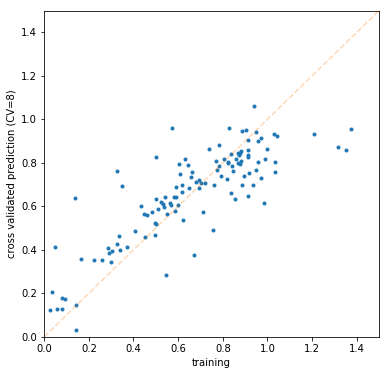

In [18]:
plot_train_pred(y, y_hat, lim)

In [19]:
mean_squared_error(y, y_hat)

0.026795879082426637

In [20]:
y_test = elanet.predict(X_test_prep)

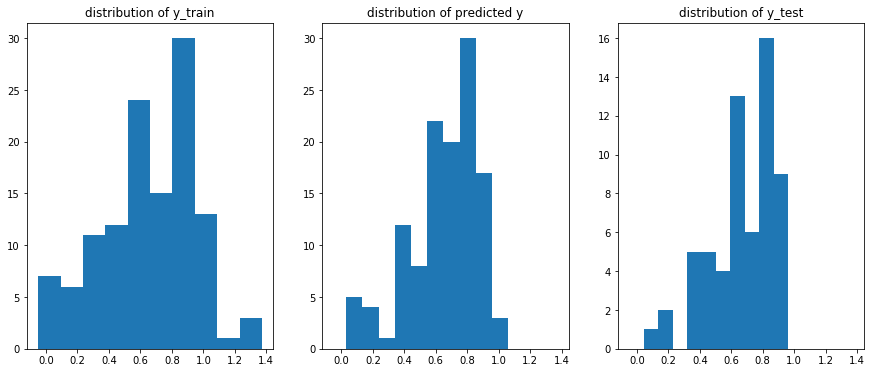

In [21]:
plot_pred_distribution(y, y_hat, y_test)

In [22]:
pd.DataFrame(
    y_test, 
    index=X_test.droplevel('Organism Code').index, 
    columns=['pred'], 
    dtype='float'
).to_csv('../output/performance_elanet.csv')

In [23]:
joblib.dump(elanet, '../models/performance_elanet.pkl')

['../models/performance_elanet.pkl']

# ElasticNet with PCA

In [24]:
pca = PCA(0.98)

In [25]:
X_train_pca = pca.fit_transform(X_train_prep)
X_test_pca = pca.transform(X_test_prep)

In [26]:
params = dict(
#    alpha=[0.001, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0], 
    alpha=[0.005, 0.01, 0.05, 0.08, 0.1, 0.2, 0.3, 1.0], 
#    l1_ratio=[0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0], 
#    l1_ratio=[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4], 
    l1_ratio=[0.0, 0.05, 0.1, 0.2, 0.3, 0.35, 0.4, 0.45, 0.5], 
), 

grid_search = GridSearchCV(
    ElasticNet(random_state=random_state), 
    param_grid=params,
    scoring='neg_mean_squared_error', 
    n_jobs=12, 
    cv=10, 
    verbose=3, 
    iid=False, 
)

In [27]:
grid_search.fit(X_train_pca, y)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 720 out of 720 | elapsed:    0.9s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=190624, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid=False, n_jobs=12,
             param_grid=({'alpha': [0.005, 0.01, 0.05, 0.08, 0.1, 0.2, 0.3,
                                    1.0],
                          'l1_ratio': [0.0, 0.05, 0.1, 0.2, 0.3, 0.35, 0.4,
                                       0.45, 0.5]},),
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=3)

In [28]:
grid_search.best_estimator_

ElasticNet(alpha=0.08, copy_X=True, fit_intercept=True, l1_ratio=0.4,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=190624, selection='cyclic', tol=0.0001,
           warm_start=False)

In [29]:
elanet = grid_search.best_estimator_

y_hat = elanet.predict(X_train_pca)

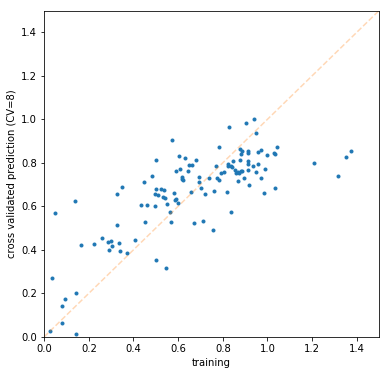

In [30]:
plot_train_pred(y, y_hat, lim)

In [31]:
mean_squared_error(y, y_hat)

0.033761774990627734

The PCA didn't help prediction.

# RandomForestRegressor

In [32]:
params = dict(
    max_depth=[3, 4, 5, 6], 
    max_features=['sqrt', 'log2', 'auto', 20, 23, 25, 27, 30, 35], 
    min_samples_leaf=[2, 3, 4], 
    min_samples_split=[3,4,5],
)

grid_search = GridSearchCV(
    RandomForestRegressor(n_estimators=200, random_state=random_state), 
    param_grid=params,
    scoring='neg_mean_squared_error', 
    n_jobs=16, 
    cv=8, 
    verbose=3, 
    iid=False, 
)

In [33]:
grid_search.fit(X_train_prep, y)

Fitting 8 folds for each of 324 candidates, totalling 2592 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  96 tasks      | elapsed:    2.9s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:    6.9s
[Parallel(n_jobs=16)]: Done 480 tasks      | elapsed:   10.9s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:   16.6s
[Parallel(n_jobs=16)]: Done 1120 tasks      | elapsed:   23.5s
[Parallel(n_jobs=16)]: Done 1536 tasks      | elapsed:   31.7s
[Parallel(n_jobs=16)]: Done 2016 tasks      | elapsed:   41.2s
[Parallel(n_jobs=16)]: Done 2560 tasks      | elapsed:   52.5s
[Parallel(n_jobs=16)]: Done 2592 out of 2592 | elapsed:   53.2s finished


GridSearchCV(cv=8, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=200, n_jobs=None,
                                             oob_score=False,
                                             random_state=190624, verbose=0,
                                             warm_start=False),
             iid=False, n_jobs=16,
             pa

In [34]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=190624,
                      verbose=0, warm_start=False)

In [35]:
randfor = grid_search.best_estimator_

y_hat = randfor.predict(X_train_prep)

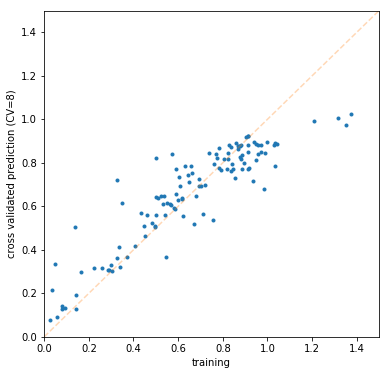

In [36]:
plot_train_pred(y, y_hat, lim)

In [37]:
mean_squared_error(y, y_hat)

0.016520974409976175

In [38]:
y_test = randfor.predict(X_test_prep)

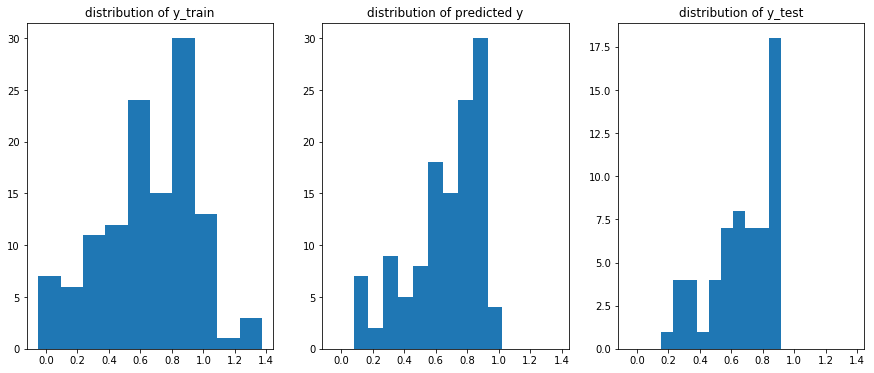

In [39]:
plot_pred_distribution(y, y_hat, y_test)

In [40]:
pd.DataFrame(
    y_test, 
    index=X_test.droplevel('Organism Code').index, 
    columns=['pred'], 
    dtype='float'
).to_csv('../output/performance_randfor.csv')

In [41]:
joblib.dump(randfor, '../models/performance_randfor.pkl')

['../models/performance_randfor.pkl']

# SVR

In [42]:
params = dict(
    kernel=['rbf', 'linear', 'sigmoid', 'poly'], 
    degree=[2, 3], 
#    gamma=['auto', 0.001, 0.003, 0.01, 0.03, 0.1, 1, 3], 
    gamma=['auto', 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.03], 
#    C=[0.001, 0.003, 0.01, 0.03, 0.1, 1, 3, 10], 
    C=[0.1, 1, 2, 2.5, 3, 3.5, 4, 5, 10], 
#    epsilon=[0.01, 0.03, 0.1, 0.3, 0.5]
    epsilon=[0.03, 0.05, 0.08, 0.1, 0.12, 0.14, 0.16, 0.2, 0.3]
)

grid_search = GridSearchCV(
    SVR(), 
    param_grid=params,
    scoring='neg_mean_squared_error', 
    n_jobs=12, 
    cv=10, 
    verbose=3, 
    iid=False, 
)

In [43]:
grid_search.fit(X_train_prep, y)

Fitting 10 folds for each of 5184 candidates, totalling 51840 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 494 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done 4654 tasks      | elapsed:    3.0s
[Parallel(n_jobs=12)]: Done 10478 tasks      | elapsed:    9.2s
[Parallel(n_jobs=12)]: Done 15977 tasks      | elapsed:   20.0s
[Parallel(n_jobs=12)]: Done 21775 tasks      | elapsed:   33.2s
[Parallel(n_jobs=12)]: Done 27105 tasks      | elapsed:   49.1s
[Parallel(n_jobs=12)]: Done 34001 tasks      | elapsed:  1.2min
[Parallel(n_jobs=12)]: Done 41764 tasks      | elapsed:  1.8min
[Parallel(n_jobs=12)]: Done 49770 tasks      | elapsed:  2.8min
[Parallel(n_jobs=12)]: Done 51840 out of 51840 | elapsed:  3.0min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid=False, n_jobs=12,
             param_grid={'C': [0.1, 1, 2, 2.5, 3, 3.5, 4, 5, 10],
                         'degree': [2, 3],
                         'epsilon': [0.03, 0.05, 0.08, 0.1, 0.12, 0.14, 0.16,
                                     0.2, 0.3],
                         'gamma': ['auto', 0.001, 0.002, 0.003, 0.004, 0.005,
                                   0.01, 0.03],
                         'kernel': ['rbf', 'linear', 'sigmoid', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=3)

In [44]:
grid_search.best_estimator_

SVR(C=3, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma=0.002,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [45]:
svr = grid_search.best_estimator_

y_hat = svr.predict(X_train_prep)

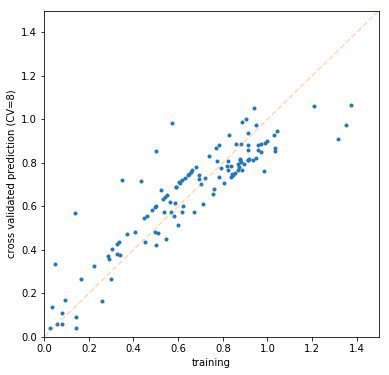

In [46]:
plot_train_pred(y, y_hat, lim)

In [47]:
mean_squared_error(y, y_hat)

0.017006569723493303

In [48]:
y_test = svr.predict(X_test_prep)

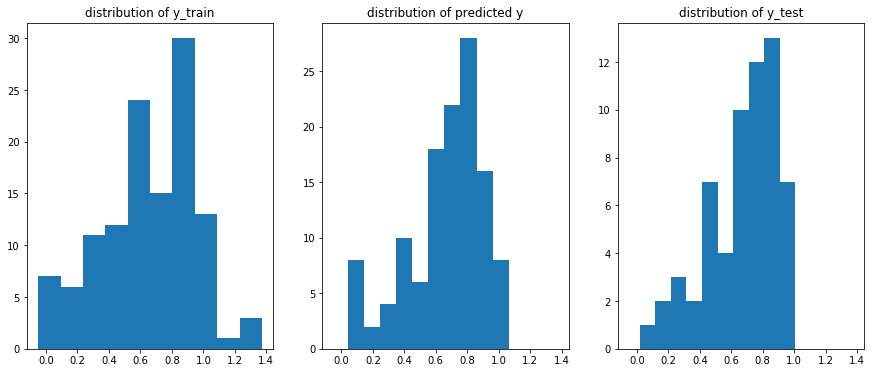

In [49]:
plot_pred_distribution(y, y_hat, y_test)

In [50]:
pd.DataFrame(
    y_test, 
    index=X_test.droplevel('Organism Code').index, 
    columns=['pred'], 
    dtype='float'
).to_csv('../output/performance_svr.csv')

In [51]:
joblib.dump(svr, '../models/performance_svr.pkl')

['../models/performance_svr.pkl']

# AdaboostRegressor - DecisionTreeRegressor

In [52]:
params = dict(
    base_estimator__max_depth=[3,4,5,6],
    base_estimator__min_samples_leaf=[3,4,5],
    base_estimator__min_samples_split=[3,4,5],
    base_estimator__max_features=['sqrt', 'log2', 0.3, 0.5, 0.7],
    learning_rate=[0.5, 1.0, 1.5]
)

grid_search = GridSearchCV(
    AdaBoostRegressor(
        base_estimator=DecisionTreeRegressor(random_state=random_state), 
        random_state=random_state,
        n_estimators=100, 
    ), 
    param_grid=params,
    scoring='neg_mean_squared_error', 
    n_jobs=16, 
    cv=8, 
    verbose=3, 
    iid=False, 
)

In [53]:
grid_search.fit(X_train_prep, y)

Fitting 8 folds for each of 540 candidates, totalling 4320 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done 160 tasks      | elapsed:    2.3s
[Parallel(n_jobs=16)]: Done 473 tasks      | elapsed:    5.6s
[Parallel(n_jobs=16)]: Done 701 tasks      | elapsed:    8.0s
[Parallel(n_jobs=16)]: Done 989 tasks      | elapsed:   11.3s
[Parallel(n_jobs=16)]: Done 1341 tasks      | elapsed:   15.2s
[Parallel(n_jobs=16)]: Done 1757 tasks      | elapsed:   19.8s
[Parallel(n_jobs=16)]: Done 2237 tasks      | elapsed:   26.2s
[Parallel(n_jobs=16)]: Done 2781 tasks      | elapsed:   32.6s
[Parallel(n_jobs=16)]: Done 3389 tasks      | elapsed:   40.7s
[Parallel(n_jobs=16)]: Done 4061 tasks      | elapsed:   48.8s
[Parallel(n_jobs=16)]: Done 4320 out of 4320 | elapsed:   52.6s finished


GridSearchCV(cv=8, error_score='raise-deprecating',
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                                              max_depth=None,
                                                                              max_features=None,
                                                                              max_leaf_nodes=None,
                                                                              min_impurity_decrease=0.0,
                                                                              min_impurity_split=None,
                                                                              min_samples_leaf=1,
                                                                              min_samples_split=2,
                                                                              min_weight_fraction_leaf=0.0,
                                                  

In [54]:
grid_search.best_estimator_

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=5,
                                                       max_features=0.7,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=4,
                                                       min_samples_split=3,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=190624,
                                                       splitter='best'),
                  learning_rate=0.5, loss='linear', n_estimators=100,
                  random

In [55]:
adaboost = grid_search.best_estimator_

y_hat = adaboost.predict(X_train_prep)

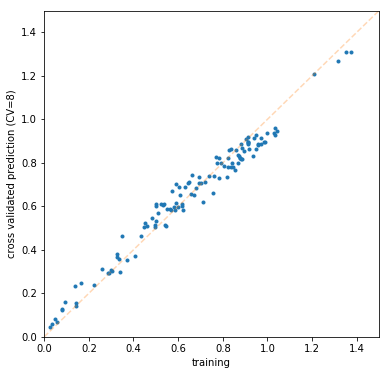

In [56]:
plot_train_pred(y, y_hat, lim)

In [57]:
mean_squared_error(y, y_hat)

0.00298158781789884

In [58]:
y_test = adaboost.predict(X_test_prep)

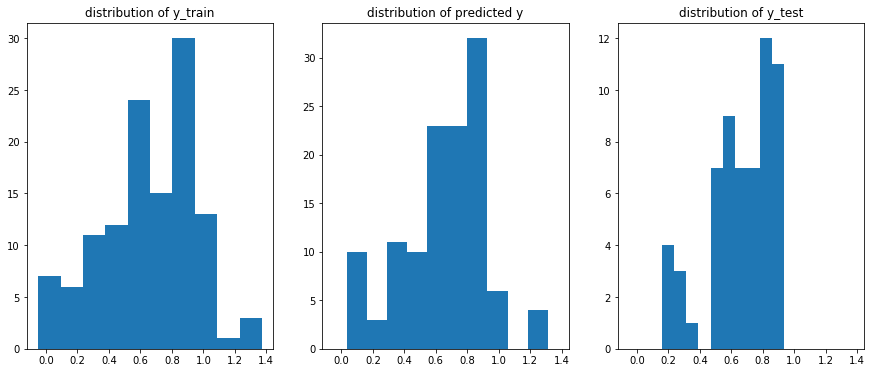

In [59]:
plot_pred_distribution(y, y_hat, y_test)

In [60]:
pd.DataFrame(
    y_test, 
    index=X_test.droplevel('Organism Code').index, 
    columns=['pred'], 
    dtype='float'
).to_csv('../output/performance_adaboost_decisiontree.csv')

In [61]:
joblib.dump(svr, '../models/performance_adaboost_decisiontree.pkl')

['../models/performance_adaboost_decisiontree.pkl']

# AdaboostRegressor - ElasticNet

In [24]:
params = dict(
    base_estimator__alpha=[0.03, 0.05, 0.08, 0.1, 0.15],
    base_estimator__l1_ratio=[0.5, 0.6, 0.7, 0.8, 0.9],
    learning_rate=[1.5]
)

grid_search = GridSearchCV(
    AdaBoostRegressor(
        base_estimator=ElasticNet(), 
        random_state=random_state, 
        n_estimators=50
    ), 
    param_grid=params,
    scoring='neg_mean_squared_error', 
    n_jobs=12, 
    cv=8, 
    verbose=3, 
    iid=False, 
)

In [25]:
grid_search.fit(X_train_prep, y)

Fitting 8 folds for each of 25 candidates, totalling 200 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    5.7s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:   24.5s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:   35.2s finished


GridSearchCV(cv=8, error_score='raise-deprecating',
             estimator=AdaBoostRegressor(base_estimator=ElasticNet(alpha=1.0,
                                                                   copy_X=True,
                                                                   fit_intercept=True,
                                                                   l1_ratio=0.5,
                                                                   max_iter=1000,
                                                                   normalize=False,
                                                                   positive=False,
                                                                   precompute=False,
                                                                   random_state=None,
                                                                   selection='cyclic',
                                                                   tol=0.0001,
                                    

In [26]:
grid_search.best_estimator_

AdaBoostRegressor(base_estimator=ElasticNet(alpha=0.08, copy_X=True,
                                            fit_intercept=True, l1_ratio=0.6,
                                            max_iter=1000, normalize=False,
                                            positive=False, precompute=False,
                                            random_state=None,
                                            selection='cyclic', tol=0.0001,
                                            warm_start=False),
                  learning_rate=1.5, loss='linear', n_estimators=50,
                  random_state=190624)

In [27]:
adaboost_elanet = grid_search.best_estimator_

y_hat = adaboost_elanet.predict(X_train_prep)

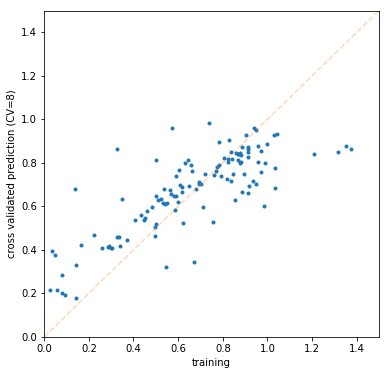

In [28]:
plot_train_pred(y, y_hat, lim)

In [29]:
mean_squared_error(y, y_hat)

0.03303091378834469

In [30]:
y_test = adaboost_elanet.predict(X_test_prep)

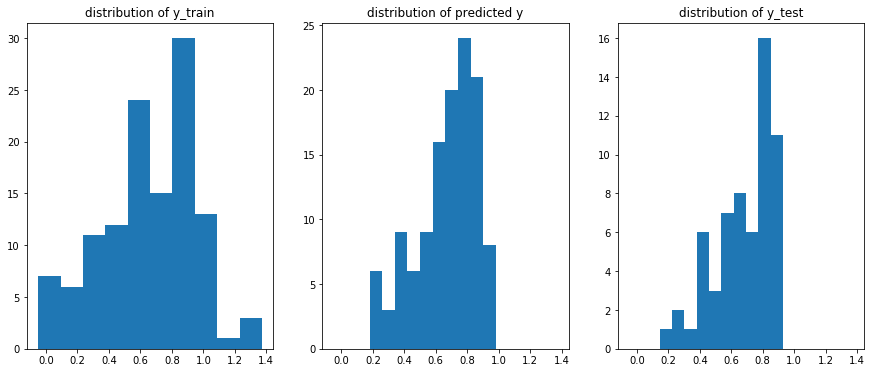

Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/z/datalake/virtual_envs/20190813T102726/Ubuntu16.04/lib/python3.5/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/joblib/externals/loky/backend/synchronize.py", line 96, in _cleanup
    sem_unlink(name)
FileNotFoundError: [Errno 2] No such file or directory
Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/z/datalake/virtual_envs/20190813T102726/Ubuntu16.04/lib/python3.5/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/joblib/externals/loky/backend/synchronize.py", line 96, in _cleanup
    sem_unlink(name)
FileNotFoundError: [Errno 2] No such file or directory
Exception ignored in: <Finalize ob

In [31]:
plot_pred_distribution(y, y_hat, y_test)

In [ ]:
pd.DataFrame(
    y_test, 
    index=X_test.droplevel('Organism Code').index, 
    columns=['pred'], 
    dtype='float'
).to_csv('../output/performance_adaboost_elanet.csv')

In [ ]:
joblib.dump(svr, '../models/performance_adaboost_elanet.pkl')

# Summary

All models perform badly on large y (>1.0).